# Benchmarking y optimización de uso de memoria

En este notebook vamos a aprender a usar herramientas para analizar qué tan rápido y eficiente es nuestro código en Julia, y mencionaremos algunas formas de optimizar operaciones.


Comenzaremos aprendiendo a medir el tiempo que toma correr una función en Julia. La forma más directa y es utilizando el macro `@time`, que retorna el tiempo que demoró la ejecución de un bloque de código.

Vamos a trabajar primero con un ejemplo sencillo: la función `sum`. Esta función nos devuelve la suma de todos los elementos de un arreglo:
$$
sum(a) = \sum_{i=1}^N a_i = a_1+a_2+...+a_N
$$

In [1]:
N = 10^7        #Definimos el tamaño del vector
a = rand(N);    #Creamos un vector de N números aleatorios entre 0 y 1

In [2]:
@time sum(a)    #Calculamos la suma de todos los elementos

  0.071195 seconds (75.40 k allocations: 4.142 MiB, 89.07% compilation time)


4.999765471575549e6

Esto nos ha dado una idea básica de cuanto costó llamar la función `sum`. Hubo alguna alocacion de memoria que requirio algunos pocos bytes, y llamarla tomó algunos milisegundos. Ahora, veamos qué sucede si medimos este tiempo de vuelta:

In [3]:
@time sum(a)

  0.007360 seconds (1 allocation: 16 bytes)


4.999765471575549e6

¡Esta vez `@time` devolvió un tiempo de ejecución distinto!, y esto es esperable. El ordenador que está usando está realizando muchísimas otras operaciones simultáneamente mientras corre este notebook, y en cada momento puede estar más o menos listo para medir el tiempo de ejecución. También es probable que haya tenido que compilar la función `sum` en la primer ejecución. Es por eso que, a la hora de medir la performance de un código, siempre es mejor cerrar la mayor cantidad de procesos posibles en la computadora para disminuir el ruido, y hacer muchas mediciones para sacar estadística.

Para esto tenemos disponible un paquete muy útil llamado `BenchmarkTools.jl`, que cargaremos a continuación:

In [4]:
#=====================================================
using Pkg
Pkg.add("BenchmarkTools")    #correr estas dos líneas si no tiene BenchmarkTools instalado
=======================================================#
using BenchmarkTools

Ahora tenemos a nuestra disposición el macro `@benchmark`. Veamos qué nos dice

In [5]:
@benchmark sum($a)

BenchmarkTools.Trial: 821 samples with 1 evaluation.
 Range (min … max):  5.459 ms …  12.620 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.862 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.072 ms ± 670.801 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁▄█▄▁▁                                                     
  ▃▅██████▇█▆▅▅▅▅▃▃▄▃▃▃▂▂▂▃▂▂▂▁▃▂▂▂▂▂▁▂▁▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▂▁▁▂ ▃
  5.46 ms         Histogram: frequency by time        9.03 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

globalesglobales`@benchmark` también midió el tiempo de ejecución, pero hizo esta corrida muchas veces y realizó estadística. Por defecto intentará hacer 10000 corridas, pero si la función tarda mucho tiempo en correr se detiene antes. Usted debería haber obtenido un output similar al siguiente (probablemente con otros números)
```
Range (min … max):  6.416 ms …  10.159 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.730 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.978 ms ± 594.557 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄▆█▄                                                       
  ▅██████▅▆▆▆▄▅▅▄▄▄▃▄▃▄▄▂▄▂▂▂▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▃▂▂▂▂▁▁▁▁▁▁▁▂▁▂▂ ▃
  6.42 ms         Histogram: frequency by time        9.46 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.
```
La forma de leer esto es: se corrió la función 739 veces. La corrida más rápida tardó 5.868 ms, la más lenta 9.189 ms, la media de la distribución de tiempos es 6.663 ms y el promedio de 6.751 ms con desviación estándar de 790.941 ms. La columna GC se refiere al tiempo gastado en procesos de "garbage collection".



**Nota**: Usamos el signo de pesos para interpolar la variable a. En general es una buena idea interpolar variables globales en `@benchmark` para que sean variables locales al benchmark.
Actualmente uno no tiene que preocuparse mucho por eso, pero hay veces en las que no interpolar puede dar resultados engañosos. Por ejemplo,
```
x = 0.5
@benchmark sin(x)
```
dará un resultado distinto que 
```
x = 0.5
@benchmark sin($x)```

pues en el primer caso Julia considerará constante el valor de `x` y hará optimizaciones en base a ello.

In [6]:
@benchmark sin(0.5)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  1.692 ns … 26.759 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.695 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.749 ns ±  0.578 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▇   ▃▄     ▁     ▁                                        ▁
  ██▁▁▁██▇▁▃▄▅█▆▁▃▄▃█▇▅▁▁▁▁▁▁▁▁▄▁▃▃▆▆▄▅▅▆▆▅▅▆▆▆▆▆▅▅▅▅▅▄▅▄▁▄▅ █
  1.69 ns      Histogram: log(frequency) by time     2.28 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [7]:
@benchmark sin($0.5)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  6.365 ns … 49.197 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.382 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.000 ns ±  1.999 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁ ▄▁▃     ▁    ▄                                 ▃        ▁
  ██▄███▄▄▄▅▄█▅▅▆▅█▆▅▆▆▅▅▅▆▆▅▅▅▃▅▄▃▄▃▅▅▅▅▄▄▄▄▁▃▁▃▃▅▄█▄▃▃▁▁▄▅ █
  6.36 ns      Histogram: log(frequency) by time     14.7 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

### Cómo manejar el resultado de `benchmark`
`@benchmark` produce una instancia de tipo `Trial`

In [8]:
t = @benchmark sum($a)
dump(t) #Lo que realmente está guardado en un Trial

BenchmarkTools.Trial
  params: BenchmarkTools.Parameters
    seconds: Float64 5.0
    samples: Int64 10000
    evals: Int64 1
    overhead: Float64 0.0
    gctrial: Bool true
    gcsample: Bool false
    time_tolerance: Float64 0.05
    memory_tolerance: Float64 0.01
  times: Array{Float64}((822,)) [5.835931e6, 5.716297e6, 5.754726e6, 5.83103e6, 5.599813e6, 5.713404e6, 5.63216e6, 5.839715e6, 5.867975e6, 6.931875e6  …  6.318489e6, 6.050725e6, 5.651085e6, 5.929085e6, 5.772442e6, 5.734632e6, 5.587779e6, 6.051909e6, 5.59717e6, 5.687236e6]
  gctimes: Array{Float64}((822,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  memory: Int64 0
  allocs: Int64 0


y podemos accedera los distintos valores utilizando las funciones `median`, `minimum`, `mean`, `maximum` o `std`. Por ejemplo:

In [9]:
median(t)

BenchmarkTools.TrialEstimate: 
  time:             5.840 ms
  gctime:           0.000 ns (0.00%)
  memory:           0 bytes
  allocs:           0

### Otros macros de `BenchmarkTools`
Para pruebas rápidas tenemos el macro `@btime`, cuya salida es similar a la de `@time`, y nos devuelve el tiempo mínimo de corrida de la función y su uso de memoria. Igualmente, `@belapsed` devuelve el mínimo tiempo en segundos.

In [10]:
@btime sum($a)


  5.468 ms (0 allocations: 0 bytes)


4.999765471575549e6

In [11]:
@belapsed sum($a)

0.005504452

**A tener en cuenta**, es posible mutar un estado externo desde un benchmark:

In [12]:
A = zeros(3);                         #Creamos un vector de 3 elementos
b = @benchmarkable fill!($A, rand()); #Creamos un benchmark de la función fill, que llena A con números
                                      #aleatorios
run(b, samples = 10)                   #Hacemos un benchmark con un único sample

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  33.000 ns … 239.000 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     34.000 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   72.300 ns ±  74.331 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                             
  █▁▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  33 ns           Histogram: frequency by time          239 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [13]:
A                                    #Verificamos A, ¡y vemos que ha sido modificado!

3-element Vector{Float64}:
 0.9197144823726912
 0.9197144823726912
 0.9197144823726912

## Trabajando eficientemente con matrices

El paquete `LinearAlgebra` provee toda una serie de herramientas que facilitan trabajar con matrices si es que tenemos información útil sobre ella. Por ejemplo, podemos decirle a Julia que una matriz es simétrica, o diagonal, o triangular superior, y esto le permitirá a Julia ser más eficiente al hacer operaciones matriciales.

Veamos algunos ejemplos:

In [14]:
using LinearAlgebra

In [15]:
A = Diagonal([1,2,3,4])  #La sintaxis de esta función es Diagonal(Arreglo), donde Arreglo
                         #son los elementos de la diagonal de la matriz

4×4 Diagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅
 ⋅  ⋅  3  ⋅
 ⋅  ⋅  ⋅  4

Julia nos muestra esta matriz con puntos en donde hay ceros. Esta es una forma de indicarnos que no está guardando en memoria estos elementos. Tratemos de hacer una pequeña comapración de velocidades. Para ello generaremos dos matrices diagonales un poco más grandes, una usando la función `Diagonal` y otra de la forma usual.

In [16]:
N = 1000
diagonal = rand(N)
x = rand(N)
A = Diagonal(diagonal)    #Creamos una matriz diagonal
B = zeros(N,N)
for i in 1:N
    B[i,i] = diagonal[i]  #Creamos una matriz idéntica de la forma usual
end


Veamos si notamos una diferencia en el tiempo que toma calcular `A*x` y `B*x`

In [17]:
@benchmark $A*$x

BenchmarkTools.Trial: 10000 samples with 15 evaluations.
 Range (min … max):  857.667 ns … 114.804 μs  ┊ GC (min … max):  0.00% … 98.11%
 Time  (median):       1.004 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.432 μs ±   4.682 μs  ┊ GC (mean ± σ):  13.47% ±  4.13%

  ▃██▅▄▃▃▂▂▃▂▁▁                         ▁▁▁                     ▂
  ███████████████▇▇█▇▆▄▄▄▁▃▄▁▁▃▃▃▁▁▃▃▃▄▇████▇█▇▇▆▆▅▅▆▅▅▆▅▅▄▆▇▇█ █
  858 ns        Histogram: log(frequency) by time       4.97 μs <

 Memory estimate: 7.94 KiB, allocs estimate: 1.

In [18]:
@benchmark $B*$x

BenchmarkTools.Trial: 7347 samples with 1 evaluation.
 Range (min … max):  408.836 μs …  25.738 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     470.728 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   651.678 μs ± 883.960 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▅▆▄▄▃▂▁▁                                                    ▁
  ███████████████▇▆▇▇▆▆▆▅▆▅▅▄▅▄▄▅▁▅▅▃▅▃▁▁▄▃▄▃▅▄▆▄▄▄▅▄▆▃▄▅▄▃▃▁▁▄ █
  409 μs        Histogram: log(frequency) by time       3.84 ms <

 Memory estimate: 7.94 KiB, allocs estimate: 1.

Debería haber notado una diferencia sustancial de tiempo de ejecución, ¡y esto para una matriz relativamente pequeña!. Veamos otro ejemplo, ahora usando la función `Tridiagonal`

In [19]:
N = 1_000_000   #Esto es 1 millón. Poner guión bajo es solo una forma de ayudar a leer el número
C = SymTridiagonal(rand(N), rand(N-1))

1000000×1000000 SymTridiagonal{Float64, Vector{Float64}}:
 0.76138   0.486284    ⋅          ⋅         …   ⋅          ⋅          ⋅ 
 0.486284  0.0905927  0.656583    ⋅             ⋅          ⋅          ⋅ 
  ⋅        0.656583   0.980688   0.0697579      ⋅          ⋅          ⋅ 
  ⋅         ⋅         0.0697579  0.492867       ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅         0.395237       ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅         ⋅          ⋅          ⋅             ⋅          ⋅      

Calculemos ahora los autovalores y autovectores de `C`. Esto debería ser un trabajo increíblemente intensivo para una matriz tan grande, pero dado que es tridiagonal la cuenta es trivial

In [20]:
@time eigmax(C)

  0.878658 seconds (823.39 k allocations: 225.448 MiB, 2.76% gc time, 29.26% compilation time)


2.5552162607477737

### Optimizando el uso de memoria

En la actualidad, los mayores problemas que uno puede encontrar a la hora de optimizar un programa se encuentran en el uso y manejo de memoria. Por ejemplo, si uno tiene dos vectores `A` y `B`, y quiere sumarlos y almacenar los resultados en un vector `C`, la mayor parte del costo computacional estará en asignar el lugar de memoria donde se almacenarán los vectores y en acceder a dichas direcciones de memoria. Por el contrario, la suma de cada elemento es algo relativamente rápido.

Por ejemplo, comparemos la multiplicación usual de matrices `A*B` con la función `mul`

In [21]:
N = 1000
A = rand(N,N)
B = rand(N,N)
C = zeros(N,N)
@benchmark $C .= $A*$B

BenchmarkTools.Trial: 127 samples with 1 evaluation.
 Range (min … max):  33.351 ms … 74.796 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     35.770 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   39.518 ms ±  9.138 ms  ┊ GC (mean ± σ):  0.46% ± 1.78%

  ▆█▆▄▅ ▅    ▂▂                             ▂                  
  █████▅██▅▁▁██▇▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▅█▅▁▅▁▁▁▁▅▁▁▁▅▁▁▁▅ ▅
  33.4 ms      Histogram: log(frequency) by time      72.4 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 2.

In [22]:
@benchmark mul!(C, A, B)   #Esta función realiza la operación A*B y la guarda en C

BenchmarkTools.Trial: 65 samples with 1 evaluation.
 Range (min … max):  32.506 ms … 236.131 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     74.009 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   77.006 ms ±  49.788 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁           ▃        ▂                                       
  ██▁▅▁▁▅▁▁▅▁▅▅█▁▇█▇▅▇▇▅█▅▁▁▁▁▁▁▁▅▁▅▁▅▁▁▅▁▁▁▅▁▁▁▁▁▁▁▁▁▁▅▅▁▁▁▁▅ ▁
  32.5 ms       Histogram: log(frequency) by time       221 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

Observe cómo `mul!` es mucho mas rápida y usa mucho menos memoria que `C .= A*B`. Esto se explica porque, en el segundo caso, Julia primero crea una matriz temporal con el resultado de la operación `A*B`, y luego guarda esos valores en `C`. Para matrices pequeñas esto no es un problema, pero mientras mayor sea el tamaño más malgastaremos memoria. No solo eso, sino que esta matriz temporal ocupará memoria hasta que sea recogida por el garbage collector, lo cual no es ideal.

**Consejo:** como regla general, es preferible evitar que las funciones creen vectores internamente si no tenemos buena información sobre su tamaño. Es preferible en cambio crear funciones que reciban vectores ya asignados en memoria y trabajar sobre ellos.

## Views

A veces tenemos una estructura de datos, como un arreglo o una matriz, y sólo nos interesa ver una única parte. Podría ser que nos interese trabajar únicamente con una fila de una matriz `A`, o trabajar únicamente con los elementos pares de un arreglo `v`.

En el primer caso, podríamos usar la sintaxis `A[k,:]`, y en el segundo usaríamos `v[2:2:end]`. Esto es muy útil, pero si tenemos que hacerlo muchas veces la sintaxis se puede volver engorrosa.

Una solución sería guardar los elementos en otra estructura, y trabajar con ella. Por ejemplo, hacer `A_k = A[k,:]` o `v_par = v[2:2:end]`. Esta solución es buena para algunas situaciones, pero tiene el inconveniente de que estamos creando estructuras nuevas y asignando memoria. Además, esto no nos permite modificar la estructura original si esa es nuestra intención.

Los `views` solucionan este problema, permitiendo crear estructuras de datos cuya información está guardada en otra estructura. Juguemos un poco con ellas:

In [23]:
#Trabajemos con el ejemplo de la matriz. Luego puede jugar con cualquier ejemplo
#que usted quiera
N = 5
A = rand(N,N)  #Creamos una matriz NxN

5×5 Matrix{Float64}:
 0.152523   0.896379  0.86178   0.128629   0.37768
 0.680635   0.72428   0.574754  0.335443   0.488715
 0.955861   0.781252  0.455857  0.0552366  0.205319
 0.0101889  0.239156  0.8663    0.0314189  0.895695
 0.161668   0.034475  0.765646  0.481843   0.107391

In [24]:
#Creamos ahora una copia de una fila k, y una view de una fila k
k = 3
A_k_copy = A[k,:]         #Copia de la fila 3
A_k_view = @view A[k,:]   #Vista de la fila 3
#A_k_view = view(A, k,:) Sintaxis alternativa

5-element view(::Matrix{Float64}, 3, :) with eltype Float64:
 0.9558606052767821
 0.7812523903499964
 0.455857220489463
 0.05523663200896112
 0.20531928284458567

In [25]:
#Modifiquemos ahora ambas estructuras y veamos que sucede con A
A_k_copy .= 1
display(A_k_copy)
display(A)


5-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0

5×5 Matrix{Float64}:
 0.152523   0.896379  0.86178   0.128629   0.37768
 0.680635   0.72428   0.574754  0.335443   0.488715
 0.955861   0.781252  0.455857  0.0552366  0.205319
 0.0101889  0.239156  0.8663    0.0314189  0.895695
 0.161668   0.034475  0.765646  0.481843   0.107391

In [26]:
A_k_view .= 1
display(A_k_view)
display(A)


5-element view(::Matrix{Float64}, 3, :) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0

5×5 Matrix{Float64}:
 0.152523   0.896379  0.86178   0.128629   0.37768
 0.680635   0.72428   0.574754  0.335443   0.488715
 1.0        1.0       1.0       1.0        1.0
 0.0101889  0.239156  0.8663    0.0314189  0.895695
 0.161668   0.034475  0.765646  0.481843   0.107391

### Mención especial: `Profile`, `ProfileView` y `ProfileVega`

Julia incorpora un paquete de base llamado `Profile` que nos da información sobre qué hace una función durante el tiempo de ejecución. Por ejemplo, nos dirá cuanto tiempo dedicó a cada parte en particular, si ha necesitado alocar memoria, e información del estilo. Para visualizar esta información existen diversos paquetes, de los cuales mencionamos `ProfileView`, que permite abrir una ventana con un gráfico del `profile`, y `ProfileVega`, que funciona en notebooks de `Jupyter`.

In [27]:
using Profile

In [28]:
using ProfileVega

function profile_test(n)
    for i = 1:n
        A = randn(100,100,20)
        m = maximum(A)
        Am = mapslices(sum, A; dims=2)
        B = A[:,:,5]
        Bsort = mapslices(sort, B; dims=1)
        b = rand(100)
        C = B.*b
    end
end


In [29]:
function profile_test(n)
    for i = 1:n
        A = randn(100,100,20)
        m = maximum(A)
        Am = mapslices(sum, A; dims=2)
        B = A[:,:,5]
        Bsort = mapslices(sort, B; dims=1)
        b = rand(100)
        C = B.*b
    end
end


profile_test (generic function with 1 method)

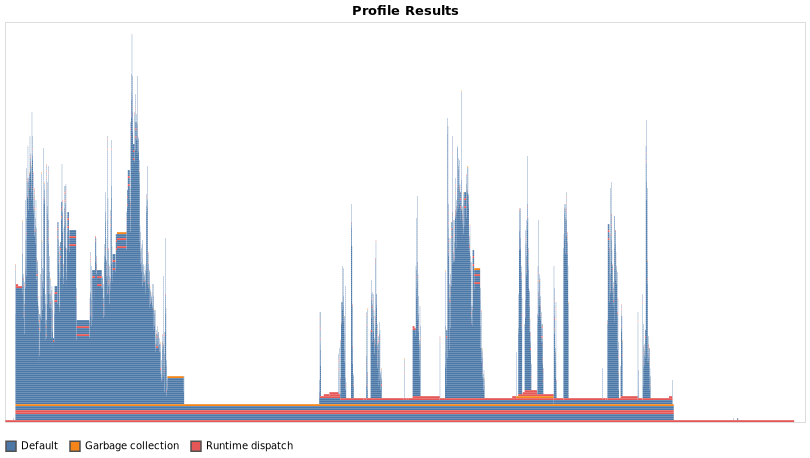

In [30]:
@profview profile_test(1)  # Hacemos una corrida para forzar la compilación de la
                           # función. Ignore este resultado


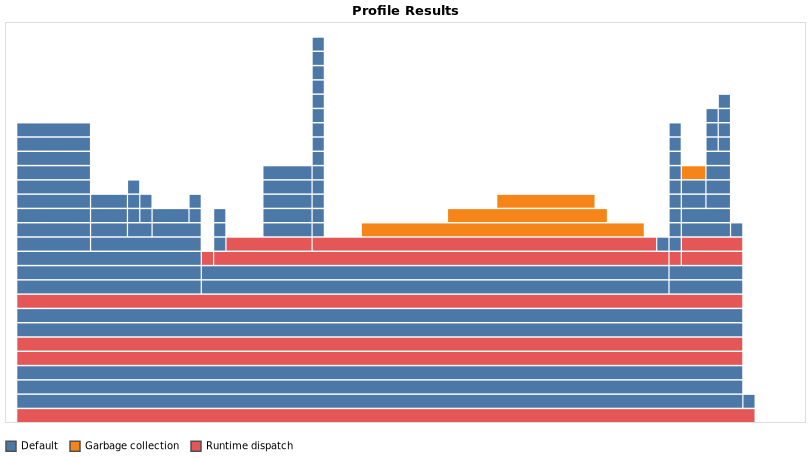

In [31]:
@profview profile_test(10) #Si coloca el cursor por encima de las barras, debería obtener
                          #información sobre qué llamada a función representa la barra.

En este gráfico, en el eje horizontal tenemos el tiempo de ejecución de la función, mientras que en el eje vertical tenemos llamadas a funciones. Cada función contiene anidadas arriba las funciones que la han llamado.